# Bringing the Data Back Together

Using Dask we'll start to do some analysis on the data.

In [1]:
# Load the packages need for work
import dask
import dask.dataframe as dd
# FDA adverse drug events analysis

# imports
import pandas as pd
import numpy as np
import json
import datetime as datetime
import requests

#sklearn
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# visualization imports
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [2]:
%%time
df = pd.read_csv('consolidatedData.csv',
        dtype={'authoritynumb': 'object',
       'patient.patientagegroup': 'float64',
       'patient.patientonsetage': 'float64',
       'patient.patientonsetageunit': 'float64',
       'patient.patientsex': 'float64',
       'seriousnesshospitalization': 'float64',
       'safetyreportid': 'object',
        'medicinalproduct':'object',
        'reactionmedrapt':'object'})

df = df.drop(columns = ['authoritynumb', 'companynumb','reportduplicate.duplicatesource',
                                'patient.patientonsetageunit','patient.patientagegroup','primarysourcecountry','V1','index', 'receiver'])
df.columns

Wall time: 3min 41s


Index(['safetyreportid', 'serious', 'receiptdate', 'occurcountry',
       'seriousnesshospitalization', 'primarysource.qualification',
       'patient.patientonsetage', 'patient.patientweight',
       'patient.patientsex', 'seriousnessother', 'seriousnesslifethreatening',
       'seriousnessdeath', 'seriousnesscongenitalanomali',
       'seriousnessdisabling', 'reactionmedrapt', 'medicinalproduct'],
      dtype='object')

In [3]:
%%time

# replace nan ages with -1
df['patient.patientonsetage'] = df['patient.patientonsetage'].fillna(-1)
# filter ages drop every age over 115 (probably reporting anomalies)
df = df.loc[df['patient.patientonsetage'] < 115]
# convert ages to ints
df['patient.patientonsetage'] = df['patient.patientonsetage'].astype(int)
df = df.loc[df['patient.patientonsetage'] >= 0]

# replace nan weights with -1
df['patient.patientweight'] = df['patient.patientweight'].fillna(-1)
# filter weights drop every weight over 635kg (the heaviest man ever) (probably reporting anomalies)
df = df.loc[df['patient.patientweight'] < 635]
# converting to int where floats aren't needed
df['patient.patientweight'] = df['patient.patientweight'].astype(int)
df = df.loc[df['patient.patientweight'] >= 0]
# replace nan sex with -1
df['patient.patientsex'] = df['patient.patientsex'].fillna(-1)
# converting to int where floats aren't needed
df['patient.patientsex'] = df['patient.patientsex'].astype(int)
df = df.loc[df['patient.patientsex']>=0]

# convert potential bool values
# fill nan with 0
# big caveat with these conversions FALSE could indicate UNREPORTED data not just FALSE
df[['seriousnesshospitalization', 'seriousnessother','seriousnesslifethreatening', 'seriousnessdeath',
       'seriousnesscongenitalanomali', 'seriousnessdisabling']] = \
       df[['seriousnesshospitalization', 'seriousnessother','seriousnesslifethreatening', 'seriousnessdeath',
              'seriousnesscongenitalanomali', 'seriousnessdisabling']].fillna(0)

# convert 1/0 columns to bol
df[['seriousnesshospitalization', 'seriousnessother','seriousnesslifethreatening', 'seriousnessdeath',
       'seriousnesscongenitalanomali', 'seriousnessdisabling']] = \
       df[['seriousnesshospitalization', 'seriousnessother','seriousnesslifethreatening', 'seriousnessdeath',
              'seriousnesscongenitalanomali', 'seriousnessdisabling']].astype('bool')

# convert receipt date to datetime
df['receiptdate'] = pd.to_datetime(df['receiptdate'],format='%Y%m%d')
df['receiptdate'] = df['receiptdate'].dt.date

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18256574 entries, 0 to 56282238
Data columns (total 16 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   safetyreportid                object
 1   serious                       int64 
 2   receiptdate                   object
 3   occurcountry                  object
 4   seriousnesshospitalization    bool  
 5   primarysource.qualification   int64 
 6   patient.patientonsetage       int32 
 7   patient.patientweight         int32 
 8   patient.patientsex            int32 
 9   seriousnessother              bool  
 10  seriousnesslifethreatening    bool  
 11  seriousnessdeath              bool  
 12  seriousnesscongenitalanomali  bool  
 13  seriousnessdisabling          bool  
 14  reactionmedrapt               object
 15  medicinalproduct              object
dtypes: bool(6), int32(3), int64(2), object(5)
memory usage: 1.4+ GB
Wall time: 32.8 s


In [4]:
%%time
df[[ 'seriousnesshospitalization','seriousnessother', 'seriousnesslifethreatening',
       'seriousnessdeath', 'seriousnesscongenitalanomali',
       'seriousnessdisabling','serious']].corr()

Wall time: 4.26 s


,seriousnesshospitalization,seriousnessother,seriousnesslifethreatening,seriousnessdeath,seriousnesscongenitalanomali,seriousnessdisabling,serious
seriousnesshospitalization,1.000000,-0.121319,0.116025,0.091714,-0.005311,-0.013320,-0.364986
seriousnessother,-0.121319,1.000000,0.035880,-0.013941,0.013394,0.040983,-0.386604
seriousnesslifethreatening,0.116025,0.035880,1.000000,0.168128,0.020244,0.109289,-0.107490
seriousnessdeath,0.091714,-0.013941,0.168128,1.000000,0.017384,-0.013459,-0.120924
seriousnesscongenitalanomali,-0.005311,0.013394,0.020244,0.017384,1.000000,0.032064,-0.019947
seriousnessdisabling,-0.013320,0.040983,0.109289,-0.013459,0.032064,1.000000,-0.072624
serious,-0.364986,-0.386604,-0.107490,-0.120924,-0.019947,-0.072624,1.000000


In [5]:
%%time
topReactions = df['reactionmedrapt'].value_counts()

print("Total Number of Reaction Categories: ", len(topReactions))
print("average of the times reported: ",np.mean(topReactions))
print("High number of times reported: ", max(topReactions))
print("Lowest number of times reported: ", min(topReactions))


Total Number of Reaction Categories:  13946
average of the times reported:  1309.0903484870214
High number of times reported:  256604
Lowest number of times reported:  1
Wall time: 1.75 s


In [6]:
%%time

#list of most commonly reported reactions
topReactions = topReactions[:10]
topReactions = topReactions.index
topReactions = list(topReactions)
topReactions.append('Death')
topReactions

Wall time: 1e+03 µs


['Diarrhoea',
 'Nausea',
 'Dyspnoea',
 'Fatigue',
 'Pyrexia',
 'Pneumonia',
 'Vomiting',
 'Headache',
 'Acute kidney injury',
 'Off label use',
 'Death']

In [7]:
%%time
#filter the list by topReactions
df = df[df['reactionmedrapt'].isin(topReactions)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2050287 entries, 199 to 56281900
Data columns (total 16 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   safetyreportid                object
 1   serious                       int64 
 2   receiptdate                   object
 3   occurcountry                  object
 4   seriousnesshospitalization    bool  
 5   primarysource.qualification   int64 
 6   patient.patientonsetage       int32 
 7   patient.patientweight         int32 
 8   patient.patientsex            int32 
 9   seriousnessother              bool  
 10  seriousnesslifethreatening    bool  
 11  seriousnessdeath              bool  
 12  seriousnesscongenitalanomali  bool  
 13  seriousnessdisabling          bool  
 14  reactionmedrapt               object
 15  medicinalproduct              object
dtypes: bool(6), int32(3), int64(2), object(5)
memory usage: 160.3+ MB
Wall time: 1.28 s


In [8]:
topMeds = df['medicinalproduct'].value_counts()
topMeds = topMeds[:500]
topMeds = topMeds.index
df = df[df['medicinalproduct'].isin(topMeds)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1275717 entries, 204 to 56281900
Data columns (total 16 columns):
 #   Column                        Non-Null Count    Dtype 
---  ------                        --------------    ----- 
 0   safetyreportid                1275717 non-null  object
 1   serious                       1275717 non-null  int64 
 2   receiptdate                   1275717 non-null  object
 3   occurcountry                  1269650 non-null  object
 4   seriousnesshospitalization    1275717 non-null  bool  
 5   primarysource.qualification   1275717 non-null  int64 
 6   patient.patientonsetage       1275717 non-null  int32 
 7   patient.patientweight         1275717 non-null  int32 
 8   patient.patientsex            1275717 non-null  int32 
 9   seriousnessother              1275717 non-null  bool  
 10  seriousnesslifethreatening    1275717 non-null  bool  
 11  seriousnessdeath              1275717 non-null  bool  
 12  seriousnesscongenitalanomali  1275717 n

In [9]:
df['observation'] = 1

df= df.pivot_table(index=['safetyreportid', 'serious', 'receiptdate', 'occurcountry',
       'seriousnesshospitalization', 'primarysource.qualification',
       'patient.patientonsetage', 'patient.patientweight',
       'patient.patientsex', 'seriousnessother', 'seriousnesslifethreatening',
       'seriousnessdeath', 'seriousnesscongenitalanomali',
       'seriousnessdisabling', 'reactionmedrapt'], columns='medicinalproduct', values='observation', fill_value=0).reset_index()

In [10]:
df['reactionmedrapt'].value_counts(normalize=True)

Nausea                 0.120706
Diarrhoea              0.120159
Dyspnoea               0.117137
Fatigue                0.100006
Vomiting               0.087874
Off label use          0.086249
Headache               0.084480
Pyrexia                0.083401
Pneumonia              0.077407
Acute kidney injury    0.069759
Death                  0.052821
Name: reactionmedrapt, dtype: float64

                     precision    recall  f1-score   support

Acute kidney injury    0.27145   0.42059   0.32995      9432
              Death    0.13463   0.36676   0.19696      7111
          Diarrhoea    0.21646   0.18501   0.19950     16194
           Dyspnoea    0.23503   0.16119   0.19123     15733
            Fatigue    0.20286   0.13984   0.16555     13473
           Headache    0.17211   0.28466   0.21452     11431
             Nausea    0.18478   0.04863   0.07700     16223
      Off label use    0.23568   0.43953   0.30683     11626
          Pneumonia    0.21538   0.17996   0.19608     10430
            Pyrexia    0.23325   0.21542   0.22398     11294
           Vomiting    0.20097   0.04915   0.07898     11862

           accuracy                        0.20798    134809
          macro avg    0.20933   0.22643   0.19824    134809
       weighted avg    0.21084   0.20798   0.19111    134809

                     precision    recall  f1-score   support

Acute kidney injury 

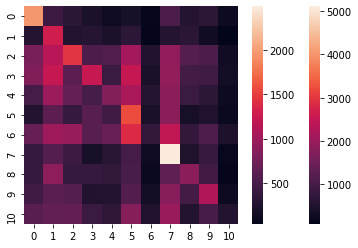

In [11]:
modelData = df.iloc[:,np.r_[14,6:9,15:515]]
dfTrain, dfTest = train_test_split(modelData, test_size=.33, random_state=19, shuffle=True)

x_train = dfTrain.iloc[:,1:]
y_train = dfTrain.iloc[:,0]
x_test = dfTest.iloc[:,1:]
y_test = dfTest.iloc[:,0]

nb = MultinomialNB()

nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)

sns.heatmap(confusion_matrix(y_train,nb.predict(x_train)))
print(classification_report(y_train,nb.predict(x_train), digits=5))

sns.heatmap(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred, digits=5))

                     precision    recall  f1-score   support

Acute kidney injury    0.87139   0.88285   0.87708      9432
              Death    0.87688   0.87034   0.87360      7111
          Diarrhoea    0.69810   0.69668   0.69739     16194
           Dyspnoea    0.75566   0.76743   0.76150     15733
            Fatigue    0.69694   0.69420   0.69557     13473
           Headache    0.66943   0.67711   0.67325     11431
             Nausea    0.63223   0.63410   0.63316     16223
      Off label use    0.87420   0.88225   0.87821     11626
          Pneumonia    0.83291   0.82205   0.82745     10430
            Pyrexia    0.76072   0.75890   0.75981     11294
           Vomiting    0.63733   0.61836   0.62770     11862

           accuracy                        0.74171    134809
          macro avg    0.75507   0.75493   0.75497    134809
       weighted avg    0.74142   0.74171   0.74153    134809

                     precision    recall  f1-score   support

Acute kidney injury 

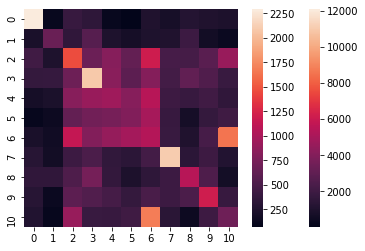

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf.fit(x_train, y_train)
y_pred = rf_clf.predict(x_test)

sns.heatmap(confusion_matrix(y_train,rf_clf.predict(x_train)))
print(classification_report(y_train,rf_clf.predict(x_train), digits=5))

sns.heatmap(confusion_matrix(y_test,y_pred))
print(classification_report(y_test, y_pred, digits=5))